In [1]:
import sys; sys.path.append('..'); from wwa import *

Xn, Xx, Yn, Yx = [-67,-47,-27,-7]
xn, xx, yn, yx = [-60,-54,-23,-15]
mapproj = cartopy.crs.PlateCarree()

In [2]:
sf = gpd.read_file("sf/pantanal")

# Pantanal shapefile
Region of interest is the flood plain of the upper Paraguay river - use hydrobasin to refine area, then cut to within Brazil (could also include part of Bolivia?) & possibly use elevation to further restrict to just the floodplain

In [21]:
# clip shapefile to just Brazil
sf_hybas = gpd.read_file("sf/hybas04").loc[[83]]

gdf_br = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_crs(epsg = 4326).set_index("abbrevs").loc[["BR", "BO"]]
sf_hybas_pan = main_polygon(sf_hybas.clip(gdf_br)).clip([-60.75,-23,-50,-10])

sf_hybas_pan.to_file("sf/hybas_br-bo")

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/geopandas/geodataframe.py:2233: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)
/rds/general/user/cb2714/home/wwa/24-06-20_brazil-wildfires/../wwa.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.loc[gdf.geometry.area == gdf.geometry.area.max()]


In [6]:
# Pantanal biome shapefile
# ! cd data; wget http://geoftp.ibge.gov.br/informacoes_ambientais/estudos_ambientais/biomas/vetores/Biomas_250mil.zip; unzip data/Biomas_250mil.zip -d sf/biomas

In [3]:
# shapefile of Brazilian Pantanal from https://brasil.mapbiomas.org/en/mapas-de-referencia/
sf_biomas = gpd.read_file("sf/biomas").loc[[5]].to_crs(epsg = 4326)
sf_biomas.to_file("sf/pantanal")

## Compile & filter active fire data

In [2]:
# MODIS active fire pixels
# ! cd data; wget https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_M-C61_489623.zip; unzip data/DL_FIRE_M-C61_489623.zip -d data

In [9]:
# load all active fire data
df = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("data/*M-C61*.csv")])

# filter out low-confidence points
df = df.loc[(df.confidence >= 80), ["latitude", "longitude"]]

df.to_csv("data/modis_conf-80.csv")

### Count of daily active pixel area

In [65]:
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf)

px_daily = df.resample("D").count()[["geometry"]]
px_daily.rename(columns = {"geometry" : "px"}).to_csv("data/modis-active-pixels_pantanal.csv")

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/geopandas/geodataframe.py:2233: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


# ERA5 FWI & subindices

## Download via API

In [12]:
xn, xx, yn, yx = [-60,-54,-23,-15]

In [ ]:
import cdsapi

c = cdsapi.Client()

for y in range(1992, 1949,-1):
    
    print(y)
    new_fnm = 'data/era5-fire/fwi-subindices_cons_'+str(y)+'.nc'
    if os.path.exists(new_fnm): continue
    
    c.retrieve(
        'cems-fire-historical-v1',
        {
            'product_type': 'reanalysis',
            'variable': [
                'build_up_index', 'drought_code', 'duff_moisture_code',
                'fine_fuel_moisture_code', 'initial_fire_spread_index',
                'keetch_byram_drought_index',
            ],
            'dataset_type': 'consolidated_dataset',
            'system_version': '4_1',
            'year': str(y),
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'grid': '0.25/0.25',
            'format': 'netcdf',
            'area': [
                yx, xn, yn, xx,
            ],
        },
        new_fnm)
    clear_output(wait = False)

2024-07-18 17:45:45,699 INFO Welcome to the CDS
2024-07-18 17:45:45,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-fire-historical-v1


1992


2024-07-18 17:45:45,834 INFO Request is queued


In [ ]:
import cdsapi

c = cdsapi.Client()

for y in range(2023, 2025):
    
    c.retrieve(
        'cems-fire-historical-v1',
        {
            'product_type': 'reanalysis',
            'variable': [
                'build_up_index', 'drought_code', 'duff_moisture_code',
                'fine_fuel_moisture_code', 'initial_fire_spread_index',
                'keetch_byram_drought_index',
            ],
            'dataset_type': 'intermediate_dataset',
            'system_version': '4_1',
            'year': str(y),
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'grid': '0.25/0.25',
            'format': 'netcdf',
            'area': [
                yx, xn, yn, xx,
            ],
        },
        'data/era5-fire/fwi-subindices_int_'+str(y)+'.nc')
    clear_output(wait = False)

## Get DSR
Downloaded to project drive via API

In [4]:
# Compile FWI data into a single file
fl = sorted(glob.glob("../../00_WWA_project_folder/live/data/era5_fire/*consolidated*.nc"))

fwi_cns = [wrap_lon(xr.open_dataset(fnm)).fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx)).reset_coords(drop = True) for fnm in fl]

int_start = (fwi_cns[-1].time[-1]+1)

fwi_int = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/era5_fire/era5_025_fwi_intermediate.nc"))
fwi_int = fwi_int.fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx), time = slice(int_start, None)).reset_coords(drop = True)

fwi = xr.concat(fwi_cns + [fwi_int], "time")
fwi = fwi.assign_attrs(note = "Intermediate data after "+str(fwi_int.time.min().values)[:10])
fwi = fwi.assign_coords(time = fwi.time.dt.floor("D")).rename("fwi")
fwi.to_netcdf("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")

dsr = (0.0272 * (fwi ** 1.71)).rename("dsr")
dsr.to_netcdf("data/era5_dsr_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")

## Compile DSR & sub-indices into daily time series over study region

In [6]:
fl = sorted(glob.glob("data/era5-fire/*cons*.nc"))

# make generic regionmask
ds = xr.open_dataset(fl[0]).reset_coords(drop = True)
rm = regionmask.mask_geopandas(sf, ds.longitude, ds.latitude)

fwi_cns = xr.concat([xr.open_dataset(fnm).reset_coords(drop = True).where(rm == 0).mean(["latitude", "longitude"]) for fnm in fl], "time")

int_start = fwi_cns.time[-1]+1

fwi_int = xr.concat([xr.open_dataset(fnm).reset_coords(drop = True).where(rm == 0).mean(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5-fire/*int*.nc"))], "time")

fwi_si = xr.concat([fwi_cns, fwi_int.sel(time = slice(fwi_cns.time[-1]+1, None))], "time")
fwi_si = fwi_si.assign_attrs(note = "Intermediate data after "+str(fwi_cns.time[-1].time.min().values)[:10])

In [15]:
# merge with FWI & DSR, relabel & save as a single netcdf

fwi = xr.open_dataset("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc").fwi
fwi_ts = fwi.where(regionmask.mask_geopandas(sf, fwi.longitude, fwi.latitude) == 0).mean(["latitude", "longitude"])

dsr = xr.open_dataset("data/era5_dsr_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc").dsr
dsr_ts = dsr.where(regionmask.mask_geopandas(sf, dsr.longitude, dsr.latitude) == 0).mean(["latitude", "longitude"])

In [16]:
ds_era5 = xr.merge([fwi_si, fwi_ts, dsr_ts], join = "outer")
ds_era5 = ds_era5.rename({"fbupinx" : "bui", "drtcode" : "dc", "dufmcode" : "dmc", "ffmcode" : "ffmc", "infsinx": "isi"})

ds_era5.to_netcdf("data/fwi_daily_pantanal_era5.nc")

## Contributing variables

### Relative humidity

In [ ]:
for y in range(2024, 1949,-1):
    
    print(y)
    new_fnm = '/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/era5/rhum_1000hpa_'+str(y)+'.nc'
    if os.path.exists(new_fnm): continue
        
    c.retrieve(
        'reanalysis-era5-pressure-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': 'relative_humidity',
            'pressure_level': '1000',
            'year': str(y),
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                -15, -60, -23,
                -54,
            ],
        },
        new_fnm)
    clear_output(wait = False)

### Subset of daily min & daily mean rh

In [3]:
fpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/era5/"

In [21]:
for y in range(1950,2025):
    ds = xr.open_dataset(fpath+"rhum_1000hpa_"+str(y)+".nc").r
    if "expver" in ds.dims: ds = ds.sum("expver")
        
    ds.resample(time = "D").mean().to_netcdf(fpath+"daily/rhum-mean_1000hpa_"+str(y)+".nc")
    ds.resample(time = "D").min().to_netcdf(fpath+"daily/rhum-min_1000hpa_"+str(y)+".nc")

In [4]:
rmean = xr.open_mfdataset(fpath+"daily/rhum-mean_*.nc")
rmin = xr.open_mfdataset(fpath+"daily/rhum-min_*.nc")

In [5]:
rmean.to_netcdf("data/rhum-mean_era5.nc")
rmin.to_netcdf("data/rhum-min_era5.nc")

### Compile daily time series of all variables

In [6]:
# data at 0.5deg from Climate Explorer
tmax = xr.open_dataset("data/era5_tmax_daily_-60--54E_-23--15N_su.nc").tmax
tmax = tmax.where(regionmask.mask_geopandas(sf, tmax.lon, tmax.lat) == 0).mean(["lat", "lon"])

t2m = xr.open_dataset("data/era5_t2m_daily_-60--54E_-23--15N_su.nc").t2m
t2m = t2m.where(regionmask.mask_geopandas(sf, t2m.lon, t2m.lat) == 0).mean(["lat", "lon"]).rename("tas")

tp = xr.open_dataset("data/era5_tp_daily_-60--54E_-23--15N_su.nc").tp
tp = tp.where(regionmask.mask_geopandas(sf, tp.lon, tp.lat) == 0).mean(["lat", "lon"]).rename("pr")

sfcWind = xr.open_dataset("data/era5_sfcWind_daily_-60--54E_-23--15N_su.nc").sfcWind
sfcWind = sfcWind.where(regionmask.mask_geopandas(sf, sfcWind.lon, sfcWind.lat) == 0).mean(["lat", "lon"])

In [13]:
# data at 0.25deg from CDS hourly at 1000hpa
rhmean = xr.open_dataset("data/rhum-mean_era5.nc").r
rhmean = rhmean.where(regionmask.mask_geopandas(sf, rhmean.longitude, rhmean.latitude) == 0).mean(["latitude", "longitude"]).rename("rh_mean")

rhmin = xr.open_dataset("data/rhum-min_era5.nc").r
rhmin = rhmin.where(regionmask.mask_geopandas(sf, rhmin.longitude, rhmin.latitude) == 0).mean(["latitude", "longitude"]).rename("rh_min")

In [14]:
era5_vars = xr.merge([t2m, tmax, tp, sfcWind, rhmean, rhmin], join = "inner")
era5_vars.to_netcdf("data/vars_daily_pantanal_era5.nc")

### Monthly variables

In [65]:
ds = xr.open_dataset("data/era5_monthly_pr-t-wspd.nc").sum("expver")

# mask off region
rm = regionmask.mask_geopandas(sf, ds.longitude, ds.latitude)
ds = ds.where(rm == 0).mean(["latitude", "longitude"])

# sort out units
ds["t2m"] = convert_units_to(ds["t2m"], "degC")
ds["tp"] = convert_units_to(ds["tp"], "mm")
ds["si10"] = convert_units_to(ds["si10"], "m/s")

In [67]:
# get monthly means & save as .csv
ts_mj = ds.rolling(time = 2).mean().groupby("time.month")[6]
ts_mj.assign_coords(time = ts_mj.time.dt.year).rename(time = "year").to_dataframe().to_csv("data/era5_variables_may-june.csv")

ts_jun = ds.groupby("time.month")[6]
ts_jun.assign_coords(time = ts_jun.time.dt.year).rename(time = "year").to_dataframe().to_csv("data/era5_variables_june.csv")

# MSWX

## Extract data


In [4]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/mswx/"

xn, xx, yn, yx = [-62,-52,-24,-12]

In [4]:
for varnm in ["P", "Tmax", "Tmin", "Wind", "RelHum"]:
    print(varnm)
    for y in range(1979,2025):
        
        print("  "+str(y))
        
        new_fnm = outpath+varnm+"_"+str(y)+".nc"
        if os.path.exists(new_fnm): continue
        
        da = wrap_lon(xr.open_mfdataset(fpath+varnm+"/"+str(y)+"/*.nc")).sel(lon = slice(xn,xx), lat = slice(yn,yx))
        da.to_netcdf(new_fnm)
        
    clear_output(wait = False)

## Compile each variable

In [3]:
convert_units_to(xr.open_mfdataset(outpath+"P_*.nc").precipitation, "mm/day").rename("pr").to_netcdf("data/mswx/pr_mswx.nc")

In [4]:
convert_units_to(xr.open_mfdataset(outpath+"Tmax_*.nc").air_temperature, "degC").rename("tasmax").to_netcdf("data/mswx/tasmax_mswx.nc")

In [5]:
convert_units_to(xr.open_mfdataset(outpath+"Wind_*.nc").wind_speed, "m/s").rename("sfcWind").to_netcdf("data/mswx/sfcWind_mswx.nc")

In [6]:
convert_units_to(xr.open_mfdataset(outpath+"RelHum_*.nc").relative_humidity, "%").rename("hurs").to_netcdf("data/mswx/hurs_mswx.nc")

## Compute FWI


In [8]:
from xclim.indicators.atmos import cffwis_indices

ds = xr.merge([xr.open_dataset("data/mswx/"+varnm+"_mswx.nc") for varnm in ["pr", "tasmax", "sfcWind", "hurs"]])
fwi = cffwis_indices(ds = ds.rename(tasmax = "tas"))
xr.merge(fwi).to_netcdf("data/mswx/fwi-subindices_mswx.nc")

In [8]:
# daily time series of FWI/DSR & subindices
fwi["dsr"] = (0.0272 * (fwi.fwi ** 1.71))
rm = regionmask.mask_geopandas(sf, fwi.lon, fwi.lat)
ts = fwi.where(rm == 0).mean(["lat", "lon"])
ts.to_netcdf("data/fwi_daily_pantanal_mswx.nc")

In [19]:
# save variables as daily time series
rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
ts = ds.where(rm == 0).mean(["lat", "lon"])
ts.to_netcdf("data/vars_daily_pantanal_mswx.nc")

# MERRA2 (corrected)

_FWI data downloaded from https://data.giss.nasa.gov/impacts/gfwed/_

In [ ]:
import os
from IPython.display import clear_output

# download all monthly files from NASA
for y in [str(y) for y in range(2024,1979,-1)]:
    
    ! mkdir -p /rds/general/user/cb2714/home/99_ephemera/merra_corrected/$y
    
    for m in [str(m).rjust(2, "0") for m in range(1,13)]:
        
        for d in [str(d).rjust(2, "0") for d in range(1,32)]:
            
            url = "https://portal.nccs.nasa.gov/datashare/GlobalFWI/v2.0/fwiCalcs.MERRA2/Default/MERRA2.CORRECTED/"+str(y)+"/FWI.MERRA2.CORRECTED.Daily.Default."+y+m+d+".nc"
            outfile = "/rds/general/user/cb2714/home/99_ephemera/merra_corrected/"+y+"/"+url.split("/")[-1]

            if os.path.exists(outfile): continue
            ! wget $url -O $outfile

            clear_output(wait = False)
            
    # delete any files of size zero (nonexistent dates)
    ! find /rds/general/user/cb2714/home/99_ephemera/merra_corrected/$y/ -size 0 -delete
    
print("Done.")

## Compile & subset yearly data

In [10]:
for y in [fp[-4:] for fp in sorted(glob.glob("/rds/general/user/cb2714/home/99_ephemera/merra_corrected/*"))[1:]]:
    
    print(y)
    new_fnm = "data/merra/merra-corrected_fwi_"+y+".nc"
    if os.path.exists(new_fnm): continue
    
    fl = sorted(glob.glob("/rds/general/user/cb2714/home/99_ephemera/merra_corrected/"+y+"/*"))
    
    # open files for a single year, assign dates & relabel
    ds = xr.concat([xr.open_dataset(fnm).assign_coords(time = [pd.to_datetime(fnm[-11:-3], format='%Y%m%d').to_numpy()]) for fnm in fl], "time")
    
    # relabel variables to something less unwieldy
    ds = ds.rename({k : k.split("_")[-1].lower() for k in list(ds.data_vars)})
    
    da = ds.sel(lon = slice(xn, xx), lat = slice(yn,yx)).to_netcdf(new_fnm)
    
clear_output(wait = False)

## Compile all years & extract daily time series over study region

In [14]:
ds = xr.open_mfdataset("data/merra/*.nc")
rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
ds = ds.where(rm == 0).mean(["lat", "lon"])

ds.to_netcdf("data/fwi_daily_pantanal_merra2-corrected.nc")

# MERRA2 (not bias corrected)

_FWI data downloaded from https://data.giss.nasa.gov/impacts/gfwed/_

**Currently only at monthly resolution**

In [39]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/02_wwa-private/canada-wildfires/data/merra/FWI.MERRA2*.nc"))
zz = [xr.open_dataset(fnm).assign_coords(time = [pd.to_datetime(fnm[-9:-3]+"01", format = "%Y%m%d")]) for fnm in fl]
ds = xr.concat(zz, "time").rename({k : k.split("_")[-1].lower() for k in list(ds.data_vars)})

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [ ]:
ds.sel(lon = slice(xn, xx), lat = slice(yn,yx)).to_netcdf("data/merra-monthly.nc")

In [45]:
rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
ts = ds.where(rm == 0).mean(["lat", "lon"])
ts.to_netcdf("data/fwi_monthly_pantanal_merra2.nc")

### Compare corrected vs uncorrected

In [52]:
unc = xr.open_dataset("data/fwi_monthly_pantanal_merra2.nc").groupby("time.month")[6]
bc = xr.open_dataset("data/fwi_daily_pantanal_merra2-corrected.nc").resample(time = "MS").mean().groupby("time.month")[6]

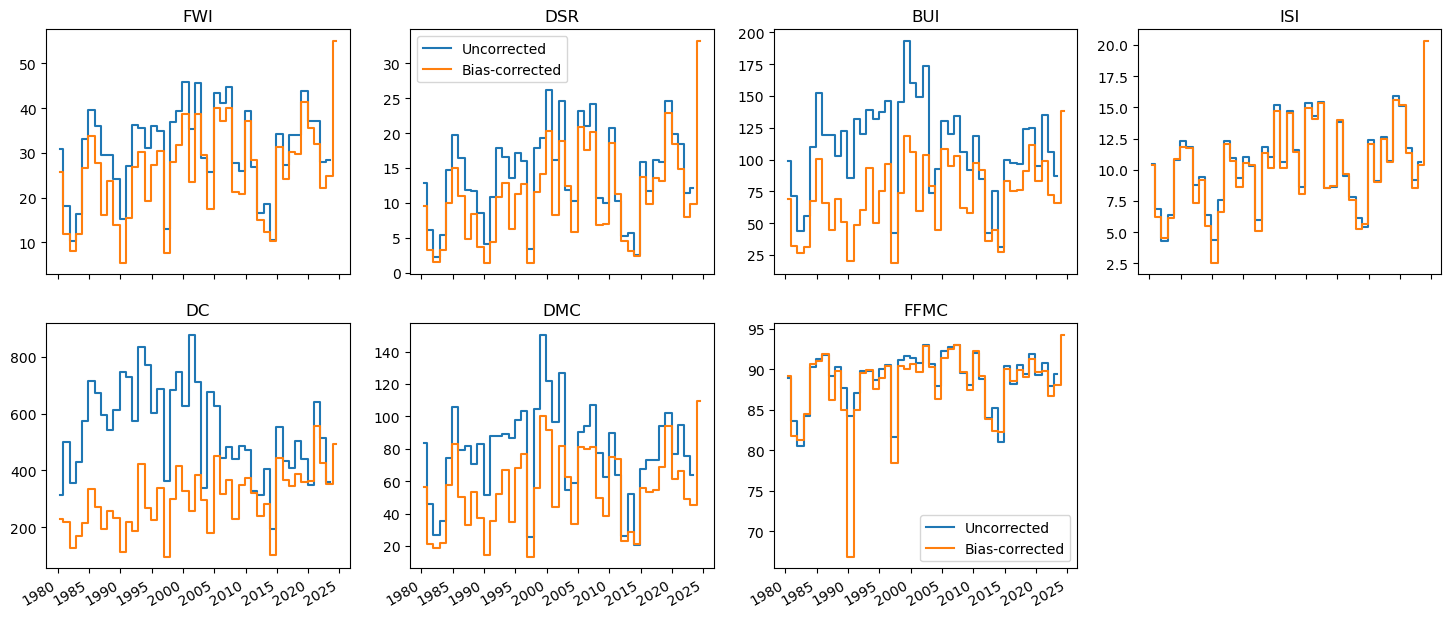

In [64]:
nc = 4; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4.5, nr*3.5), dpi = 100, sharex = True)

varbls = ["fwi", "dsr", "bui", "isi", "dc", "dmc", "ffmc"]

for i in range(len(varbls)):
    ax = fig.axes[i]
    vnm = varbls[i]
    
    unc[vnm].plot(ax = ax, drawstyle = "steps-mid", label = "Uncorrected")
    bc[vnm].plot(ax = ax, drawstyle = "steps-mid", label = "Bias-corrected")
    ax.set_title(vnm.upper())
    ax.set_ylabel("")
    ax.set_xlabel("")

for i in [1,6]: fig.axes[i].legend()
for i in range(len(varbls), len(fig.axes)): fig.axes[i].set_axis_off()

## CHIRPS

In [3]:
chirps = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/*.nc")).precip.rename("pr")
chirps = chirps.sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
chirps.to_netcdf("data/chirps.nc")

In [4]:
rm = regionmask.mask_geopandas(sf, chirps.longitude, chirps.latitude)
chirps_ts = chirps.where(rm == 0).mean(["latitude", "longitude"])
chirps_ts.to_netcdf("data/pr_daily_pantanal_chirps.nc")

## MERGE

### Download data

In [3]:
import os
from IPython.display import clear_output

# download all monthly files from NASA
for y in [str(y) for y in range(2023,1999,-1)]:
    
    ! mkdir -p /rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/$y
    
    for m in [str(m).rjust(2, "0") for m in range(1,13)]:
        
        for d in [str(d).rjust(2, "0") for d in range(1,32)]:
            
            url = "https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/"+y+"/"+m+"/MERGE_CPTEC_"+y+m+d+".grib2"
            outfile = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/"+y+"/"+url.split("/")[-1]

            if os.path.exists(outfile): continue
            ! wget $url -O $outfile

            clear_output(wait = False)
            
    # delete any files of size zero (nonexistent dates)
    ! find /rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/$y/ -size 0 -delete
    
print("Done.")

### Compile for each year

In [ ]:
# get subregion for each year
for y in [fp[-4:] for fp in sorted(glob.glob("/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/*"))][-1:]:
    
    print(y)
    new_fnm = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/merge_"+y+".nc"
    if os.path.exists(new_fnm): continue
    
    fl = sorted(glob.glob("/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/"+y+"/*.grib2"))
    ds_list = [xr.open_dataset(fnm).expand_dims("time").reset_coords(drop = True).prec for fnm in fl]
    ds = wrap_lon(xr.concat(ds_list, "time")).sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
    ds = convert_units_to(wrap_lon(ds), "mm", context = "hydro").rename("pr")
    ds.to_netcdf("/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/merge_"+y+".nc")
    
clear_output(wait = False)
print("Done.")

### Compile all years & extract daily time series over shapefile

In [ ]:
ds = xr.open_mfdataset("/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/merge/*.nc")
rm = regionmask.mask_geopandas(sf, ds.longitude, ds.latitude)
ts = ds.where(rm == 0).mean(["latitude", "longitude"])
ts.to_netcdf("data/pr_daily_pantanal_merge.nc")

---


---
# Time series for climate explorer

## June DSR

In [6]:
for ds in ["era5", "mswx", "merra2-corrected"]:
    
    ds_name = {"era5" : "ERA5", "mswx" : "MSWX", "merra2-corrected" : "MERRA2 (corrected)"}[ds]
    
    dsr = xr.open_dataset("data/fwi_daily_pantanal_"+ds+".nc")["dsr"]
    dsr_jun = dsr.resample(time = "MS").sum().groupby("time.month")[6]
    dsr_jun = dsr_jun.assign_coords(time = dsr_jun.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "pantanal-fires_dsr-june_"+ds
        
    csv_fullpath = "ts_obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_name+" June DSR in the Brazilian Pantanal - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# dsr [] June accumulated daily severity rating averaged over the Brazilian Pantanal at "+csv_fnm+".dat"
    head = "# year dsr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    dsr_jun.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

## DJF precip

In [71]:
for ds in ["mswx", "era5-05", "chirps"]:
    
    ds_name = {"era5-05" : "ERA5", "mswx" : "MSWX", "chirps" : "CHIRPS"}[ds]
    pr = xr.open_dataset("data/pr_daily_pantanal_"+ds+".nc").pr

    pr_djf = pr.resample(time = "QS-DEC").sum().groupby("time.season")["DJF"]
    pr_djf = pr_djf.where(pr.resample(time = "MS").mean().resample(time = "QS-DEC").count().groupby("time.season")["DJF"] == 3).dropna("time", "any")
    pr_djf = pr_djf.assign_coords(time = pr_djf.time.dt.year + 1).rename(time = "year").to_dataframe()
    
    csv_fnm = "pantanal-fires_pr-djf_"+ds
        
    csv_fullpath = "ts_obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_name+" DJF precipitation in the Brazilian Pantanal - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm/season] December-Februrary accumulated precipitation (labelled in February) averaged over the Brazilian Pantanal at "+csv_fnm+".dat"
    head = "# year pr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    pr_djf.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

## July-June precip

In [ ]:
for ds in ["mswx", "era5-05", "chirps"]:
    
    ds_name = {"era5-05" : "ERA5", "mswx" : "MSWX", "chirps" : "CHIRPS"}[ds]
    
    pr = xr.open_dataset("data/pr_daily_pantanal_"+ds+".nc").pr.sel(time = slice(None, "2024-06-30"))
    pr_jj = pr.resample(time = "AS-JUL").sum()
    pr_jj = pr_jj.where(pr.resample(time = "MS").mean().resample(time = "AS-JUL").count() == 12).dropna("time", "any")
    pr_jj = pr_jj.assign_coords(time = pr_jj.time.dt.year + 1).rename(time = "year").to_dataframe()
    
    csv_fnm = "pantanal-fires_pr-jj_"+ds
        
    csv_fullpath = "ts_obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_name+" July-June precipitation in the Brazilian Pantanal - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm/year] July-June accumulated precipitation (labelled in June) averaged over the Brazilian Pantanal at "+csv_fnm+".dat"
    head = "# year pr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    pr_jj.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

## DJF Nino

In [7]:
ts = pd.read_csv("/rds/general/user/cb2714/home/01_wwa/10_misc/detrended_nino34/nino_djf.csv", index_col = "year")

csv_fnm = "pantanal-fires_nino-djf_ersst"

csv_fullpath = "ts_obs/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: DJF mean of detrended Nino3.4 index (2024 denotes 2023-24) - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
str2 = "# nino [degC] December-February mean of Nino3.4 detrended by subtracting mean of tropical SSTs at "+csv_fnm+".dat"
head = "# year nino"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

## SAMST
South American mean surface temperature

In [47]:
samst = xr.open_dataset("data/iera5_t2m_daily_IPBES_South_America_su.nc").t2m

# 4-year smooth of July-June mean temperature
samst_4y = samst.resample(time = "AS-JUL").mean().rolling(time = 4, min_periods = 3, center = True).mean().dropna("time", "any")
samst_4y = samst_4y.assign_coords(time = samst_4y.time.dt.year + 1).rename("samst", time = "year").to_dataframe()

In [51]:
csv_fnm = "pantanal-fires_samst_era5"
        
csv_fullpath = "ts_obs/samst_era5.dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 smoothed mean of South American air temperatures - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
str2 = "# samst [degC] 4-year smoothed July-June average of air temperatures over the IPBES South America region at "+csv_fnm+".dat"
head = "# year samst"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
samst_4y.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

---
# Vapour-pressure deficit

In [11]:
A = -1.0440397e+4
B = -11.29465
C = -2.7022355e-2
D = 1.289036e-5
E = -2.4780681e-9
F = 6.5459673

In [27]:
rh = xr.open_dataset("data/mswx/hurs_mswx.nc").hurs
t = convert_units_to(xr.open_dataset("data/mswx/tasmax_mswx.nc").tasmax, "degF") + 459.67

vp_sat = np.exp(A/t + B + C*t + D*(t**2) + E*(t**3) + F*np.log(t))
vpd = vp_sat * (1 - rh.max() / 100)

vpd.rename("vpd").to_netcdf("data/mswx/vpd_mswx.nc")

In [29]:
vpd_ts = vpd.where(regionmask.mask_geopandas(sf, vpd.lon, vpd.lat) == 0).mean(["lat", "lon"])

In [36]:
vpd_june = vpd_ts.resample(time = "MS").mean().groupby("time.month")[6]
rh_june = rh.where(regionmask.mask_geopandas(sf, rh.lon, rh.lat) == 0).mean(["lat", "lon"]).resample(time = "MS").mean().groupby("time.month")[6]

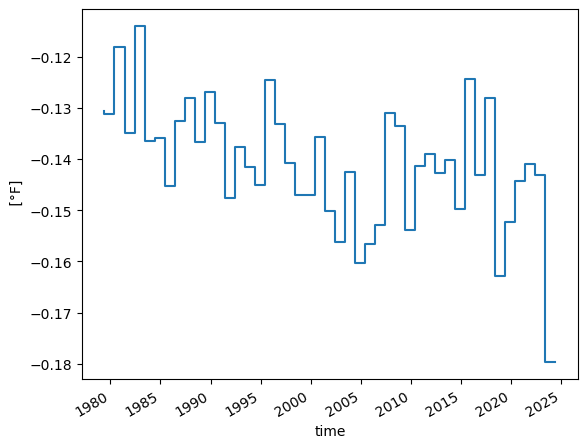

In [39]:
vpd_june.plot(drawstyle = "steps")

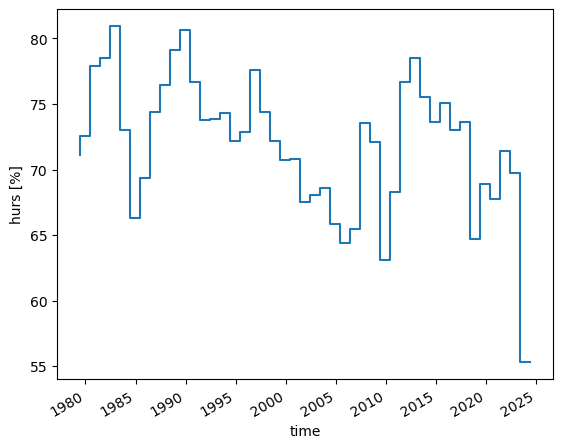

In [38]:
rh_june.plot(drawstyle = "steps")

---
---
# CMIP6

## Check available models
```
synda search variable=pr,hurs,tasmax,sfcWind -l 10000 > cmip6-models.txt
```

In [7]:
df = pd.read_table("cmip6-models.txt", sep = "\.", engine = "python", header = None,
                  names = [0,"activity", "source_id", "experiment", "variant_label", "frequency", "variable", "grid", "version"])

In [8]:
# identify models with all four variables available in both historical & SSP experiments
mdl_xvar = df[["source_id", "variant_label", "variable", "experiment"]].drop_duplicates()
mdl_xvar = mdl_xvar.groupby(["source_id", "variant_label"]).count().reset_index()

mdl_xvar = mdl_xvar.loc[mdl_xvar.variable == 8]

In [9]:
# filter models to show only those with all four variables
df = pd.merge(df, mdl_xvar, left_on = ["source_id", "variant_label"], right_on = ["source_id", "variant_label"], how = "inner")

# get list of model variants to include in synda download
",".join(sorted(df.source_id.drop_duplicates().to_list()))

'CMCC-ESM2,CanESM5,EC-Earth3,EC-Earth3-Veg,FGOALS-g3,INM-CM4-8,INM-CM5-0,IPSL-CM6A-LR,KACE-1-0-G,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,NorESM2-MM,TaiESM1'

In [10]:
# which variant labels provide most runs?
nmod = df.groupby(["variant_label"]).count()[["source_id"]] / 8
nmod.sort_values("source_id")

,source_id
variant_label,
r101i1p1f1,1.00
r150i1p1f1,1.00
r14i1p2f1,1.00
r149i1p1f1,1.00
r148i1p1f1,1.00
...,...
r6i1p1f1,5.00
r4i1p1f1,7.00
r2i1p1f1,7.25


In [11]:
# list models with all available data for run r1i1p1f1 (this is the single most commonly used label)
df.loc[df.variant_label == "r1i1p1f1", ["source_id", "grid"]].drop_duplicates().sort_values("source_id")

,source_id,grid
1890,CMCC-ESM2,gn
828,CanESM5,gn
204,EC-Earth3,gr
84,EC-Earth3-Veg,gr
540,FGOALS-g3,gn
1770,INM-CM4-8,gr1
1778,INM-CM5-0,gr1
8,IPSL-CM6A-LR,gr
916,KACE-1-0-G,gr
1074,MIROC6,gn


In [12]:
# count of model variants
df[["source_id", "variant_label"]].drop_duplicates().groupby(["source_id"]).count()

,variant_label
source_id,
CMCC-ESM2,1
CanESM5,50
EC-Earth3,58
EC-Earth3-Veg,1
FGOALS-g3,3
INM-CM4-8,1
INM-CM5-0,1
IPSL-CM6A-LR,7
KACE-1-0-G,3


## Check downloaded data

In [13]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/*/*/*.nc"))
df = pd.DataFrame([fnm.split("/")[-1].split("_") for fnm in fl], columns = ["variable", "frequency", "source_id", "experiment", "ensemble_id", "grid", "timeslice"])

In [14]:
df["ys"] = [int(t[:4]) for t in df.timeslice]
df["ye"] = [int(t[9:13]) for t in df.timeslice]

In [15]:
df = merge_byindex([df[["source_id", "variable", "ys"]].groupby(["source_id", "variable"]).min(),
                       df[["source_id", "variable", "ye"]].groupby(["source_id", "variable"]).max()]).reset_index()

In [16]:
# list models with data spanning the minimum period required for all four variables
mcount = df.loc[(df.ys <= 1900) & (df.ye >= 2050)].groupby(["source_id"]).count()[["variable"]]
mlist = mcount.loc[mcount.variable == 4].index.to_list()
mlist

['CMCC-ESM2',
 'CanESM5',
 'EC-Earth3',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-MM']

## Extract subset for FWI variables

16 unique models for which all necessary variables are available for both historical and SSP585 runs (see above)

In [18]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/cmip6/"

In [14]:
units = {"hurs" : "%", "pr" : "mm/day", "tasmax" : "degC", "sfcWind" : "m/s"}

In [15]:
for mdl in mlist:
        
    print(mdl, end = ": ")
    for varnm in ["hurs", "pr", "sfcWind", "tasmax"]:
        
        print(varnm, end = " ")
        
        new_fnm = outpath+varnm+"_"+mdl+"_r1i1p1f1.nc"
        if os.path.exists(new_fnm): continue
        
        fl = sorted(glob.glob(fpath+"/"+mdl+"/"+varnm+"/*.nc"))
        ds = wrap_lon(xr.open_mfdataset(fl)[varnm].reset_coords(drop = True))
        
        ds = ds.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))
        ds = convert_units_to(ds, units[varnm])
        
        ds.to_netcdf(new_fnm)
        
    print("")
clear_output(wait = False)

## Compile & compute FWI

In [19]:
from xclim.indicators.atmos import cffwis_indices

In [ ]:
mlist = sorted([fp.split("_")[2] for fp in glob.glob(outpath+"hurs*.nc")])
for mdl in mlist:
    
    print(mdl)
    new_fnm = "data/cmip6/fwi_"+mdl+"_r1i1p1f1.nc"
    if os.path.exists(new_fnm): continue
        
    ds = xr.merge([xr.open_dataset(outpath + varnm+"_"+mdl+"_r1i1p1f1.nc") for varnm in ["pr", "tasmax", "sfcWind", "hurs"]])
    fwi = xr.merge(cffwis_indices(ds = ds.rename(tasmax = "tas")))
    fwi.to_netcdf(new_fnm)

## Spatial pattern & seasonal cycle for validation

In [3]:
fpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/cmip6/"

mlist = [fp.split("_")[2] for fp in glob.glob(fpath+"pr_*.nc")]

In [6]:
for mdl in mlist:
    
    print(mdl, end = ": ")
    for varnm in ["pr", "tasmax"]:
        
        print(varnm, end = " ")
        
        new_fnm = "data/cmip6/"+varnm+"-spatial_"+mdl+"_r1i1p1f1.nc"
        if os.path.exists(re.sub("spatial", "seasonal", new_fnm)): continue
            
        da = xr.open_dataset(fpath+varnm+"_"+mdl+"_r1i1p1f1.nc")[varnm].sel(time = slice("1990", "2020")).load()
        
        # spatial pattern
        sp = da.groupby("time.month").mean()
        sp.to_netcdf(new_fnm)
        
        # seasonal cycle
        rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
        ts = da.where(rm == 0).mean(["lat", "lon"])
        sc = ts.groupby("time.dayofyear").mean()
        sc.to_netcdf(re.sub("spatial", "seasonal", new_fnm))
        
    print("")
clear_output(wait = False)

## Time series for climate explorer

In [18]:
for fnm in sorted(glob.glob("data/cmip6/fwi_*.nc")):
    
    mdl = fnm.split("_")[1]
    
    fwi = xr.open_dataset(fnm).fwi
    dsr = (0.0272 * (fwi ** 1.71)).rename("dsr")
    rm = regionmask.mask_geopandas(sf, fwi.lon, fwi.lat)
    ts = dsr.where(rm == 0).mean(["lat", "lon"])
    ts_jun = ts.resample(time= "MS").sum().groupby("time.month")[6]
    ts_jun = ts_jun.assign_coords(time = ts_jun.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "pantanal-fires_dsr-june_cmip6_"+mdl
        
    csv_fullpath = "ts_cmip6/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" r1i1p1f1 June DSR in the Brazilian Pantanal - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# dsr [] June accumulated daily severity rating averaged over the Brazilian Pantanal at "+csv_fnm+".dat"
    head = "# year dsr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts_jun.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

---
# CORDEX

## Check available models
```
synda search domain=SAM-22,SAM-44 variable=pr,hurs,tasmax,sfcWind -l 10000 > cordex-models.txt
```

In [2]:
df = pd.read_table("cordex-models.txt", sep = "\.", engine = "python", header = None,
                   names = [0,1,"domain", "institute", "driving_model", "experiment", "ensemble", "rcm_name","rcm_version", "frequency", "variable", "version"])

In [3]:
# identify models with all four variables available in both historical & SSP experiments
mdl_xvar = df[["domain", "driving_model", "ensemble", "rcm_name", "variable", "experiment"]].drop_duplicates()
mdl_xvar = mdl_xvar.groupby(["domain", "driving_model", "ensemble", "rcm_name"]).count().reset_index()

mdl_xvar.loc[mdl_xvar.variable == 8]

,domain,driving_model,ensemble,rcm_name,variable,experiment
0,SAM-22,MOHC-HadGEM2-ES,r1i1p1,REMO2015,8,8
1,SAM-22,MOHC-HadGEM2-ES,r1i1p1,RegCM4-7,8,8
2,SAM-22,MPI-M-MPI-ESM-LR,r1i1p1,REMO2015,8,8
3,SAM-22,MPI-M-MPI-ESM-MR,r1i1p1,RegCM4-7,8,8
4,SAM-22,NCC-NorESM1-M,r1i1p1,REMO2015,8,8
5,SAM-22,NCC-NorESM1-M,r1i1p1,RegCM4-7,8,8
6,SAM-44,CCCma-CanESM2,r1i1p1,RCA4,8,8
7,SAM-44,CCCma-CanESM2,r1i1p1,WRF341I,8,8
8,SAM-44,CNRM-CERFACS-CNRM-CM5,r1i1p1,RCA4,8,8
9,SAM-44,CSIRO-QCCCE-CSIRO-Mk3-6-0,r1i1p1,RCA4,8,8


In [4]:
# filter models to show only those with all four variables
df = pd.merge(df, mdl_xvar.loc[mdl_xvar.variable == 8], left_on = ["domain", "driving_model", "ensemble", "rcm_name"], right_on = ["domain", "driving_model", "ensemble", "rcm_name"], how = "inner")

## Check downloaded data

In [5]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/cordex/*/*/*/*/*/*"))
df = pd.DataFrame([fnm.split("/")[-1].split("_") for fnm in fl], columns = ["variable", "domain", "driving_model", "experiment", "ensemble", "rcm_name", "rcm_version", "frequency", "timeslice"])
df["ys"] = [int(t[:4]) for t in df.timeslice]
df["ye"] = [int(t.split("-")[-1][:4]) for t in df.timeslice]

In [6]:
key = ["domain", "driving_model", "rcm_name", "ensemble", "rcm_version"]

# checked using full key & found no duplicated ercm version, so can drop from key
key = ["domain", "driving_model", "ensemble", "rcm_name"]
df = merge_byindex([df[key + ["variable", "ys"]].groupby(key + ["variable"]).min(),
                       df[key + ["variable", "ye"]].groupby(key + ["variable"]).max()]).reset_index()

In [8]:
# list models with data spanning the minimum period required for all four variables
mcount = df.loc[(df.ys <= 1980) & (df.ye >= 2050)].groupby(key).count()[["variable"]]
mlist = mcount.loc[mcount.variable < 4].index.to_list()
mlist

[('SAM-44', 'MOHC-HadGEM2-ES', 'r1i1p1', 'ICTP-RegCM4-3'),
 ('SAM-44', 'MPI-M-MPI-ESM-LR', 'r1i1p1', 'MPI-CSC-REMO2009'),
 ('SAM-44', 'NOAA-GFDL-GFDL-ESM2M', 'r1i1p1', 'ICTP-RegCM4-3')]

In [2]:
# manual list of models to skip (slightly easier than automating due to modelling centre in RCM name)
skip_models = ["SAM-44/MOHC-HadGEM2-ES/r1i1p1/RegCM4-3",
               "SAM-44/MPI-M-MPI-ESM-LR/r1i1p1/REMO2009",
               "SAM-44/NOAA-GFDL-GFDL-ESM2M/r1i1p1/RegCM4-3",
               "SAM-44/MPI-M-MPI-ESM-MR/r1i1p1/RegCM4-3"]

## Extract subset for FWI variables

18 unique model combinations for which all necessary variables are available for both historical and RCP85 runs (see above)

In [3]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/cordex/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/cordex/"

In [4]:
units = {"hurs" : "%", "pr" : "mm/day", "tasmax" : "degC", "sfcWind" : "m/s"}

In [5]:
# list models with all available data
model_list = glob.glob(fpath+"*/*/*/*")
model_list = [mpath for mpath in model_list if not "/".join(mpath.split("/")[-4:]) in skip_models]

In [16]:
for mpath in [m for m in model_list if "REMO" in m]:
        
    mdl = "_".join(mpath.split("/")[-4:])
    print(mdl, end = ": ")
    
    for varnm in ["hurs", "pr", "sfcWind", "tasmax"]:
        
        print(varnm, end = " ")
        new_fnm = outpath+varnm+"_"+mdl+".nc"
        if os.path.exists(new_fnm): continue

        fl = sorted(glob.glob(mpath+"/"+varnm+"/*.nc"))
        
        ds = wrap_lon(xr.concat([xr.open_dataset(fnm)[varnm] for fnm in fl], "time"))
        
        if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
            
        if "rlon" in ds.dims:
            xdim, ydim = ["rlon", "rlat"]
        elif "x" in ds.dims:
            xdim, ydim = ["x", "y"]
        else:
            print("Check coordinates: ", ds.dims)
            continue
            
        # mask region of interest
        rm = np.logical_and(np.logical_and(ds.lon >= Xn, ds.lon <= Xx), np.logical_and(ds.lat >= Yn, ds.lat <= Yx))
        rm = rm.where(rm == 1).dropna(xdim, "all").dropna(ydim, "all")

        ds = ds.sel({xdim : rm[xdim], ydim : rm[ydim]})
        
        # convert units & save
        ds = convert_units_to(ds, units[varnm])
        ds.to_netcdf(new_fnm)
        
    print("")
        
clear_output(wait = False)

## Compile & compute FWI

In [20]:
from xclim.indicators.atmos import cffwis_indices
import xclim

In [21]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/cordex/"
mlist = sorted(["_".join(fp.split("_")[2:]) for fp in glob.glob(outpath+"hurs*.nc")])

In [22]:
for mdl in mlist:
    
    print(mdl)
    new_fnm = "data/cordex/fwi_"+mdl
    if os.path.exists(new_fnm): continue
    
    ds_list = {varnm : xr.open_dataset(outpath + varnm+"_"+mdl) for varnm in ["pr", "tasmax", "sfcWind", "hurs"]}
    ds = xr.merge([ds_list[varnm][varnm] for varnm in ["pr", "tasmax", "sfcWind", "hurs"]])
    ds = ds.assign_coords(lon = ds_list["pr"]["lon"], lat = ds_list["pr"]["lat"])
    
    with xclim.set_options(
        data_validation="log",
    ):
        fwi = xr.merge(cffwis_indices(ds = ds.rename(tasmax = "tas")))
    
    fwi.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

Done.


## Spatial pattern & seasonal cycle for validation

In [18]:
fpath = "/rds/general/user/cb2714/home/99_ephemera/pantanal-fires/cordex/"

mlist = ["_".join(fp.split("_")[-4:]) for fp in glob.glob(fpath+"pr_*.nc")]

In [64]:
for mdl in mlist:
    
    print(mdl, end = ": ")
    
    for varnm in ["pr", "tasmax"]:
        
        print(varnm, end = " ")
        
        new_fnm = "data/cordex/"+varnm+"-spatial_"+mdl
        if os.path.exists(re.sub("spatial", "seasonal", new_fnm)): continue
            
        da = xr.open_dataset(fpath+varnm+"_"+mdl)[varnm].sel(time = slice("1990", "2020")).load()
        
        # spatial pattern
        sp = da.groupby("time.month").mean()
        sp.to_netcdf(new_fnm)
        
        # seasonal cycle
        rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
        ts = da.where(rm == 0).mean([d for d in da.dims if not d == "time"])
        sc = ts.groupby("time.dayofyear").mean()
        sc.to_netcdf(re.sub("spatial", "seasonal", new_fnm))
        
    print("")
clear_output(wait = False)
print("Done.")

Done.


In [63]:
# fix where temperature data has no lat/lon coordinates
pr = xr.open_dataset(fpath+"pr_"+mdl)
da = da.assign_coords({"lat" : pr.lat, "lon" : pr.lon})

# spatial pattern
sp = da.groupby("time.month").mean()
sp.to_netcdf(new_fnm)

# seasonal cycle
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
ts = da.where(rm == 0).mean([d for d in da.dims if not d == "time"])
sc = ts.groupby("time.dayofyear").mean()
sc.to_netcdf(re.sub("spatial", "seasonal", new_fnm))

## Time series for climate explorer

In [13]:
for fnm in sorted(glob.glob("data/cordex/fwi_*.nc")):
    
    mdl = "_".join(re.sub("i1p1","",re.sub(".nc","",fnm)).split("_")[1:])
    csv_fnm = "pantanal-fires_dsr-june_"+mdl
        
    csv_fullpath = "ts_cordex/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    fwi = xr.open_dataset(fnm).fwi
    dsr = (0.0272 * (fwi ** 1.71)).rename("dsr")
    rm = regionmask.mask_geopandas(sf, fwi.lon, fwi.lat)
    ts = dsr.where(rm == 0).mean([d for d in dsr.dims if not d == "time"])
    ts_jun = ts.resample(time = "MS").sum().groupby("time.month")[6]
    ts_jun = ts_jun.assign_coords(time = ts_jun.time.dt.year).rename(time = "year").to_dataframe()
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CORDEX "+mdl+" June DSR in the Brazilian Pantanal - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# dsr [] June accumulated daily severity rating averaged over the Brazilian Pantanal at "+csv_fnm+".dat"
    head = "# year dsr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts_jun.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)